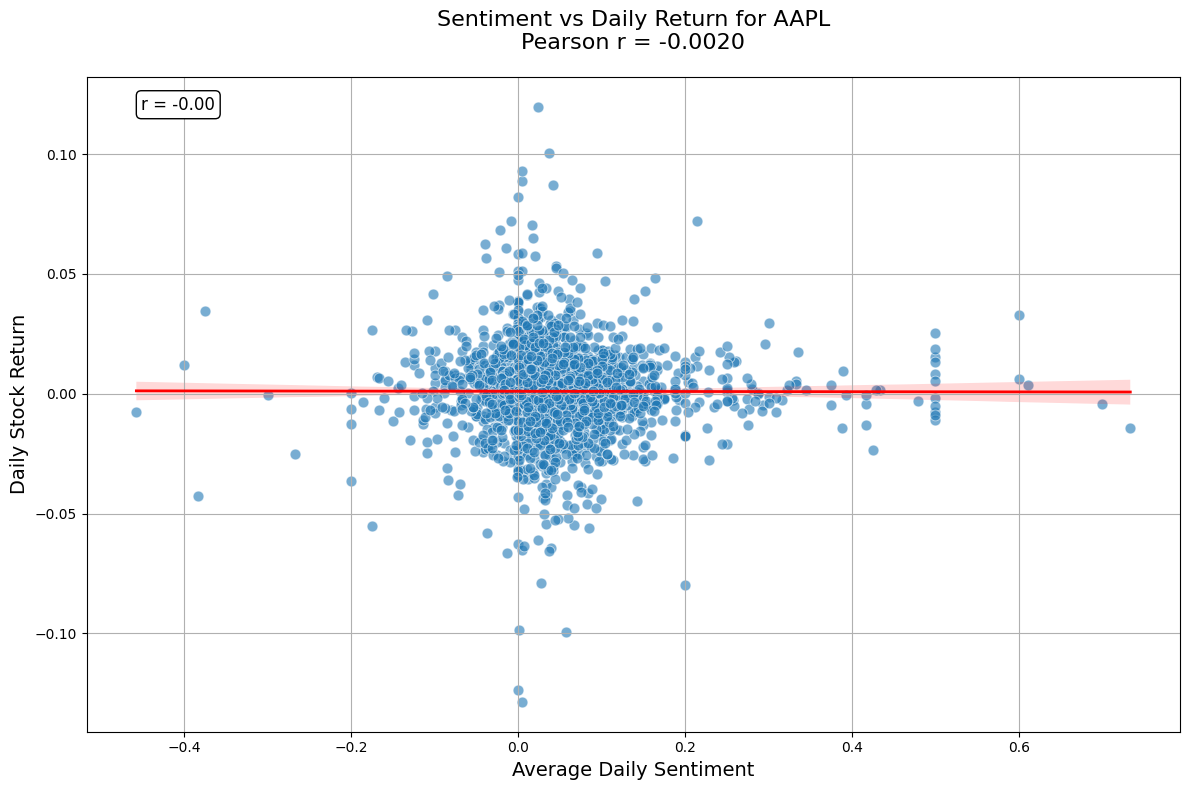

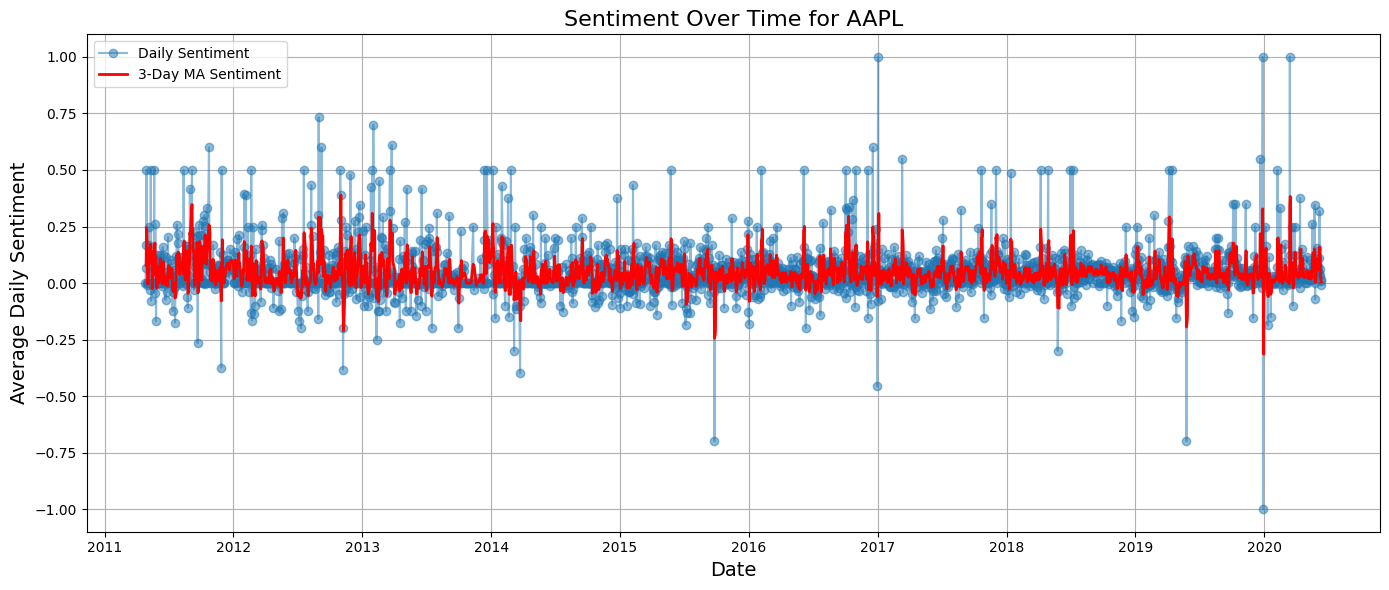

In [4]:
import os
import logging
from typing import Optional
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


class SentimentStockAnalyzer:
    def __init__(self, news_path: str, stock_path: str, stock_name: str,
                 output_dir: str = "output/sentiment_stock", show_plots: bool = False):
        self.news_path = news_path
        self.stock_path = stock_path
        self.stock_name = stock_name
        self.output_dir = os.path.abspath(output_dir)
        self.show_plots = show_plots
        os.makedirs(self.output_dir, exist_ok=True)
        self.news_df: Optional[pd.DataFrame] = None
        self.stock_df: Optional[pd.DataFrame] = None
        self.daily_sentiment: Optional[pd.DataFrame] = None

    def load_news_data(self):
        self.news_df = pd.read_csv(self.news_path)
        self.news_df['date'] = pd.to_datetime(self.news_df['date'], errors='coerce')
        self.news_df.dropna(subset=['date'], inplace=True)

    def load_stock_data(self):
        self.stock_df = pd.read_csv(self.stock_path, parse_dates=['Date'])
        self.stock_df = self.stock_df.sort_values('Date')
        self.stock_df['Daily Return'] = self.stock_df['Close'].pct_change()

    @staticmethod
    def calculate_sentiment(text: str) -> float:
        return TextBlob(str(text)).sentiment.polarity

    def add_sentiment_scores(self):
        self.news_df['Sentiment'] = self.news_df['headline'].apply(self.calculate_sentiment)

    def aggregate_daily_sentiment(self):
        self.daily_sentiment = self.news_df.groupby(self.news_df['date'].dt.date)['Sentiment'].mean().reset_index()
        self.daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)

    def merge_data(self):
        daily_returns = self.stock_df[['Date', 'Daily Return']].copy()
        daily_returns['Date'] = daily_returns['Date'].dt.date
        self.merged_df = pd.merge(self.daily_sentiment, daily_returns, on='Date', how='inner')

    def calculate_correlation(self) -> float:
        correlation = self.merged_df['Sentiment'].corr(self.merged_df['Daily Return'])
        return correlation
        
    def plot_correlation(self):
        correlation = self.calculate_correlation()
    
        plt.figure(figsize=(12, 8))
        ax = sns.scatterplot(data=self.merged_df, x='Sentiment', y='Daily Return', s=60, alpha=0.6)
        sns.regplot(data=self.merged_df, x='Sentiment', y='Daily Return',
                    scatter=False, color='red', line_kws={'linewidth': 2})
    
        plt.title(f'Sentiment vs Daily Return for {self.stock_name}\nPearson r = {correlation:.4f}',
                  fontsize=16, pad=20)
    
        ax.annotate(f'r = {correlation:.2f}',
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=12, bbox=dict(boxstyle='round', fc='white', ec='black'))
    
        plt.xlabel('Average Daily Sentiment', fontsize=14)
        plt.ylabel('Daily Stock Return', fontsize=14)
        plt.grid(True)
        plt.tight_layout()
    
        output_path = os.path.join(self.output_dir, 'sentiment_vs_return.png')
        plt.savefig(output_path)
    
        if self.show_plots:
            plt.show()
        plt.close()


    def plot_sentiment_over_time(self, ma_window=3):
        self.daily_sentiment['Sentiment_MA'] = self.daily_sentiment['Sentiment'].rolling(window=ma_window).mean()
        plt.figure(figsize=(14, 6))
        plt.plot(self.daily_sentiment['Date'], self.daily_sentiment['Sentiment'], marker='o', linestyle='-', alpha=0.5, label='Daily Sentiment')
        plt.plot(self.daily_sentiment['Date'], self.daily_sentiment['Sentiment_MA'], color='red', linewidth=2, label=f'{ma_window}-Day MA Sentiment')
        plt.title(f'Sentiment Over Time for {self.stock_name}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Average Daily Sentiment', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        output_path = os.path.join(self.output_dir, 'sentiment_over_time.png')
        plt.savefig(output_path)
        if self.show_plots:
            plt.show()
        plt.close()

    def run(self):
        self.load_news_data()
        self.load_stock_data()
        self.add_sentiment_scores()
        self.aggregate_daily_sentiment()
        self.merge_data()
        self.plot_correlation()
        self.plot_sentiment_over_time()


if __name__ == "__main__":
    news_path = '../data/raw_analyst_ratings.csv'
    stock_path = '../data/yfinance_data/AAPL_historical_data.csv'
    stock_name = 'AAPL'

    analyzer = SentimentStockAnalyzer(news_path, stock_path, stock_name, show_plots=True)
    analyzer.run()
